In [64]:
from functions0 import *
import numpy as np
import datetime
import qiskit.ignis.mitigation.measurement as mc
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_sim_jakarta = sim_noisy_jakarta 
backend = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2022-04-08 08:32:34,712: Credentials are already in use. The existing account in the session will be replaced.


In [65]:
shots=32000
precision=50
n_steps=99
check=["4copy_check", [0,2,4,6]]
evo_type="column_evolution"
time=pi
initial_state = "110"

id_tomo = "624cc0c8d720330eee67caee"
id_new_cal = "624cc0ca73968ca6f307a5a5"
id_qiskit_cal = "624cc0ccaacb9b3ca25f40c5"

job_tomo = backend.retrieve_job(id_tomo)
job_new_cal = backend.retrieve_job(id_new_cal)
job_qiskit_cal = backend.retrieve_job(id_qiskit_cal)


In [66]:
state_lables = bin_list(7)

In [67]:
meas_fitter_new_cal = mc.CompleteMeasFitter(job_new_cal.result(), state_labels=state_lables)
meas_fitter_qiskit_cal = mc.CompleteMeasFitter(job_qiskit_cal.result(), state_labels=state_lables)

U_tilde=meas_fitter_new_cal.cal_matrix

ciao
qui


In [68]:
numeric_evolution_matrix = eye(8)

for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix(time/n_steps)).evalf(precision)

# here are computed the parameters of the gates as described in "decomposition.ipynb" file.
phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(initial_state=initial_state, U=numeric_evolution_matrix)

M1_qc = fixed_magnetization_two_qubit_gate(phase_1_1,phase_1_2,a1)
M2_qc = fixed_magnetization_two_qubit_gate(phase_2_1,phase_2_2,a2)

metti apposto lo stato iniziale!
6
2


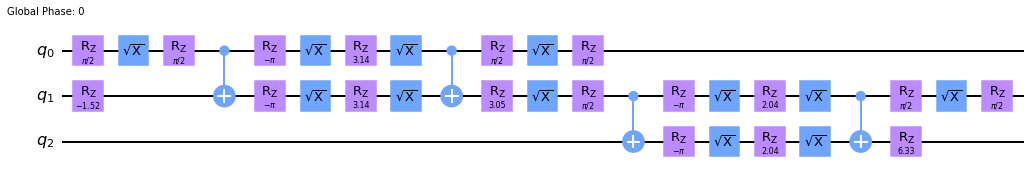

In [69]:
qr3 = QuantumRegister(3 ,name="q")
qc3 = QuantumCircuit(qr3, name="U")

qc3.append(M1_qc, [qr3[0],qr3[1]])
qc3.append(M2_qc, [qr3[1],qr3[2]])

qc3=transpile(qc3, basis_gates=["cx","rz","x","sx"])
qc3.draw(output="mpl")

In [70]:
qr_aus = QuantumRegister(7 ,name="q")
qc_aus = QuantumCircuit(qr_aus, name="U")

qc_aus.append(qc3, [qr_aus[0],qr_aus[1],qr_aus[2]])
qc_aus=add_symmetry_check(qc_aus, [qr_aus[0],qr_aus[1],qr_aus[2]], [qr_aus[3],qr_aus[4],qr_aus[5],qr_aus[6]], type="4copy_check")

U = matrix_from_cirquit(qc_aus, type="numpy")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [71]:
qr_basi = QuantumRegister(7)
qc_basi = QuantumCircuit(qr_basi)

qcs_basi = state_tomography_circuits(qc_basi,[qr_basi[0],qr_basi[1],qr_basi[2]])

C_matrices = []
C= U_tilde #np.matmul(U_tilde, np.asarray(np.matrix(U).getH()))

for qca in qcs_basi:
    
    qca.remove_final_measurements()

    qca_matrix = np.matrix(matrix_from_cirquit(qca, type="numpy"))
    qca_matrixH = qca_matrix.getH()

    C_aus = np.matmul(qca_matrix, np.matmul(C, qca_matrixH))

    C_matrices.append(np.asarray(C_aus))

In [72]:
from copy import deepcopy
meas_fitter_ours = []

for C_new in C_matrices:
    meas_fitter_our_aus = deepcopy(meas_fitter_new_cal)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitter_ours.append(meas_fitter_our_aus)

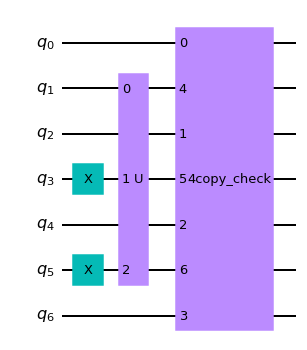

In [73]:
qr = QuantumRegister(7 ,name="q")
qc = QuantumCircuit(qr, name="U")

qc.x([qr[3],qr[5]])

qc.append(qc3, [qr[1],qr[3],qr[5]])

qc=add_symmetry_check(qc, [qr[1],qr[3],qr[5]], [qr[0],qr[2],qr[4],qr[6]], type="4copy_check")
qc.draw(output="mpl")

In [74]:
qcs_na = state_tomography_circuits(qc, [qr[1],qr[3],qr[5]]) #cirquits without ancillas measurament for the fidelity computation

In [75]:
reps=1

target_state = (One^One^Zero).to_matrix()

fids=np.zeros([reps,4])
fids_mean=np.zeros(4)
fids_dev=np.zeros(4)

for j in range(reps):
    
    #res = jobs_evo_result[j]
    res=job_tomo.result()

    print(j)
    
    new_res, new_res_nm = mitigate2(res, ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_qiskit_cal)
    new_res_our, new_res_nm = mitigate2(res, ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_ours)
    new_res_not_mitigated = mitigate2(res, ancillas_conditions=bin_list(4))

    fids[j,0] = fidelity_count(new_res_not_mitigated, qcs_na, target_state)
    fids[j,1] = fidelity_count(new_res_nm, qcs_na, target_state)
    fids[j,2] = fidelity_count(new_res, qcs_na, target_state)
    fids[j,3] = fidelity_count(new_res_our, qcs_na, target_state)

for i in range(4):
    fids_mean[i]=np.mean(fids[:,i])
    fids_dev[i]=np.std(fids[:,i])

0
0
tens_fitt
1
tens_fitt
2
tens_fitt
3
tens_fitt
4
tens_fitt
5
tens_fitt
6
tens_fitt
7
tens_fitt
8
tens_fitt
9
tens_fitt
10
tens_fitt
11
tens_fitt
12
tens_fitt
13
tens_fitt
14
tens_fitt
15
tens_fitt
16
tens_fitt
17
tens_fitt
18
tens_fitt
19
tens_fitt
20
tens_fitt
21
tens_fitt
22
tens_fitt
23
tens_fitt
24
tens_fitt
25
tens_fitt
26
tens_fitt
0
0 (128, 128)
deepcopy


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:422: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


1
1 (128, 128)
deepcopy
2
2 (128, 128)
deepcopy
3
3 (128, 128)
deepcopy
4
4 (128, 128)
deepcopy
5
5 (128, 128)
deepcopy
6
6 (128, 128)
deepcopy
7
7 (128, 128)
deepcopy
8
8 (128, 128)
deepcopy
9
9 (128, 128)
deepcopy
10
10 (128, 128)
deepcopy
11
11 (128, 128)
deepcopy
12
12 (128, 128)
deepcopy
13
13 (128, 128)
deepcopy
14
14 (128, 128)
deepcopy
15
15 (128, 128)
deepcopy
16
16 (128, 128)
deepcopy
17
17 (128, 128)
deepcopy
18
18 (128, 128)
deepcopy
19
19 (128, 128)
deepcopy
20
20 (128, 128)
deepcopy
21
21 (128, 128)
deepcopy
22
22 (128, 128)
deepcopy
23
23 (128, 128)
deepcopy
24
24 (128, 128)
deepcopy
25
25 (128, 128)
deepcopy
26
26 (128, 128)
deepcopy
attenzione ho invertito gli arg di state_fidelity
attenzione ho invertito gli arg di state_fidelity
attenzione ho invertito gli arg di state_fidelity
attenzione ho invertito gli arg di state_fidelity


In [76]:
fids_mean

array([0.76222571, 0.84333328, 0.93690022, 0.56702243])